Download data and Import Libraries

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import shap
from sklearn.utils import resample

In [118]:
transformation_names = [
    #"Original",            # No transformation
    # "PowerTransformer",    # Uses PowerTransformer (Yeo-Johnson)
    # "Log1p",               # log(x+1) transformation
    # "Sqrt",                # Square root transformation
    "BoxCox"#,              # Box-Cox transformation (with shifting if necessary)
    # "QuantileTransformer", # Maps data to a normal distribution
    # "Normalization" 
]

In [119]:
# Directory containing the CSV files
directory = './split_data'

# Dictionary to store DataFrames
dataframes = {}

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read the CSV file into a DataFrame
        df_name = filename.split('.')[0]  # Use the filename (without extension) as the key
        dataframes[df_name] = pd.read_csv(os.path.join(directory, filename))

# Display the keys of the dictionary to confirm
print(dataframes.keys())

dict_keys(['X_test_Sqrt', 'y_train', 'y_test', 'X_train_Normalization', 'data', 'X_test_Normalization', 'X_test_BoxCox', 'X_train_Original', 'X_test_PowerTransformer', 'X_train_Log1p', 'X_test_Original', 'X_train_Sqrt', 'X_train_BoxCox', 'X_train_PowerTransformer', 'X_test_Log1p', 'X_test_QuantileTransformer', 'X_train_QuantileTransformer'])


BoxCox


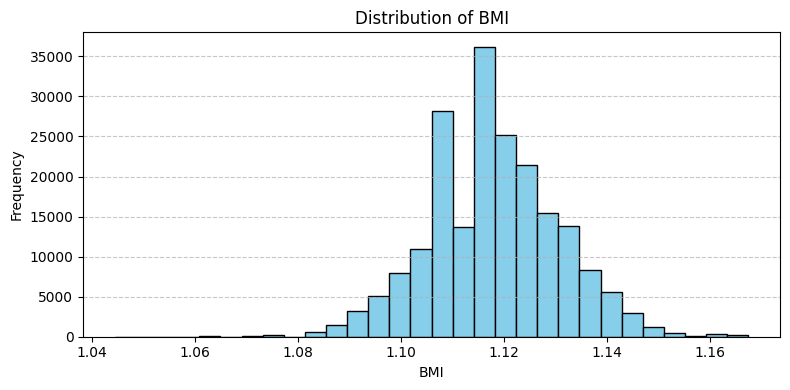

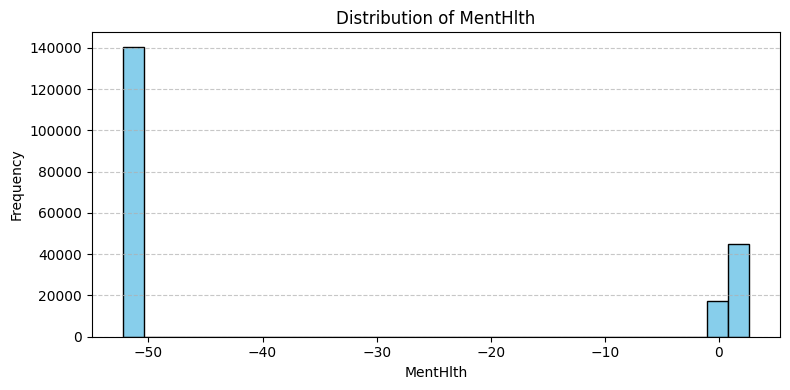

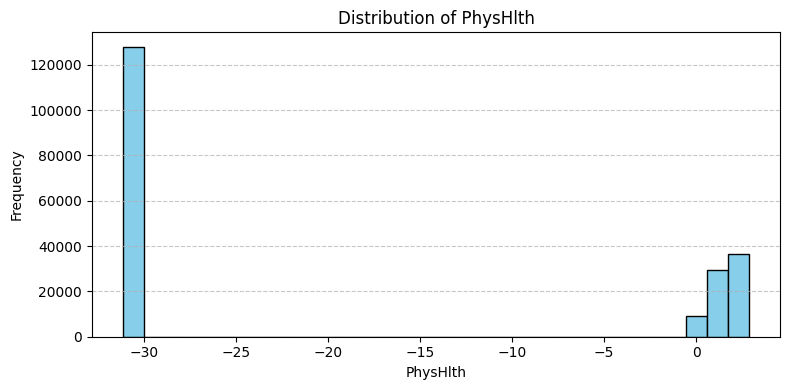

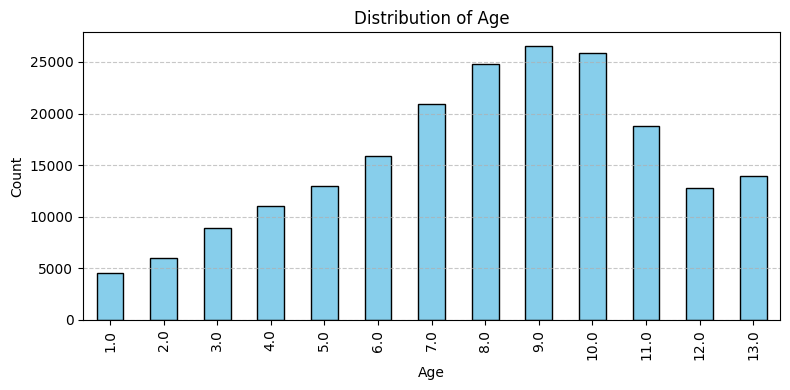

In [120]:
# Import necessary libraries
import matplotlib.pyplot as plt

features_to_visualize = ['BMI', 'MentHlth', 'PhysHlth', 'Age']

for _ in transformation_names:

    print(_)
    name = 'X_train_' + _
    X = dataframes[name]

    # Iterate through each column in X
    for col in features_to_visualize:
        plt.figure(figsize=(8, 4))
        if X[col].nunique() < 20:  # For categorical or low-cardinality features
            X[col].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
        else:  # For continuous features
            X[col].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show() 

In [ ]:
# Import necessary libraries for modeling
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler # Use MinMaxScaler to prevent negative values
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Define continuous and categorical columns for MixedNaiveBayes
continuous_cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age']
categorical_cols = [col for col in dataframes['X_train_BoxCox'].columns if col not in continuous_cols]

# Custom implementation of Naive Bayes
# Use Gaussian distribution to predict continuous variables
# Use categorical distribution to predict discrete variables
# Combine probabilities for final prediction
class MixedNaiveBayes:
    def __init__(self, continuous_cols, categorical_cols, priors=None):
        self.continuous_cols = continuous_cols
        self.categorical_cols = categorical_cols
        self.priors = priors
        if self.priors is not None:  # If class prior is provided
            self.gaussian_nb = GaussianNB(priors=self.priors)
            self.categorical_nb = CategoricalNB(fit_prior=False, class_prior=self.priors)
        else:
            self.gaussian_nb = GaussianNB()
            self.categorical_nb = CategoricalNB()
        self.has_categorical = len(categorical_cols) > 0

    def fit(self, X, y):
        # Split continuous and categorical data
        X_continuous = X[self.continuous_cols]
        if self.has_categorical:
            X_categorical = X[self.categorical_cols]
        
        # Fit GaussianNB for continuous data
        self.gaussian_nb.fit(X_continuous, y)
        
        if self.has_categorical:
            # Fit CategoricalNB for categorical data
            self.categorical_nb.fit(X_categorical, y)

    def predict(self, X):
        # Split continuous and categorical data
        X_continuous = X[self.continuous_cols]
        if self.has_categorical:
            X_categorical = X[self.categorical_cols]
        
        # Predict log probabilities for continuous and categorical data
        log_prob_continuous = self.gaussian_nb.predict_log_proba(X_continuous)
        log_prob_categorical = np.zeros_like(log_prob_continuous)
        if self.has_categorical:
            log_prob_categorical = self.categorical_nb.predict_log_proba(X_categorical)
        
        # Combine log probabilities and predict the class with maximum sum
        combined_log_prob = log_prob_continuous + log_prob_categorical
        return combined_log_prob.argmax(axis=1)

    def predict_proba(self, X):
        # Split continuous and categorical data
        X_continuous = X[self.continuous_cols]
        if self.has_categorical:
            X_categorical = X[self.categorical_cols]
        
        # Predict probabilities for continuous and categorical data
        prob_continuous = self.gaussian_nb.predict_proba(X_continuous)
        if self.has_categorical:
            prob_categorical = self.categorical_nb.predict_proba(X_categorical)
            combined_prob = prob_continuous * prob_categorical
        else:
            combined_prob = prob_continuous
        return combined_prob

# Custom implementation of LinearSVC
# Default LinearSVC does NOT support predict_proba()
# Scale the decision_function output for binary classification
class CalibratedLinearSVC(LinearSVC):
    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()
    
    def predict_proba(self, X):
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

# List of proposed models
models = {
    "LR": LogisticRegressionCV(
        scoring='f1',
        max_iter=5000
    ),
    "Tree": DecisionTreeClassifier(),
    "Forest": RandomForestClassifier(),
    "SVM": CalibratedLinearSVC(),
    "3-Layer-NeuralNetwork": MLPClassifier(
        # Achitecture proposed by Masters https://books.google.com.hk/books?hl=en&lr=&id=7Ez_Pq0sp2EC&oi=fnd&pg=PR17&ots=e32CpDOplU&sig=mhxDtt79zHuEgYGBS2CUCmPyQBw&redir_esc=y#v=onepage&q&f=false
        # from https://pmc.ncbi.nlm.nih.gov/articles/PMC5968209/
        # There is only 1 hidden layer, with sqrt(input_feature_count*output_class_count) neurons
        hidden_layer_sizes=[int((len(dataframes['X_train_Original'].columns)*2)**0.5)]
    ),
    "GradBoost": GradientBoostingClassifier(),
    "knn": KNeighborsClassifier(),
    "GauNB": GaussianNB(),
    "MixNB": MixedNaiveBayes(
        continuous_cols=continuous_cols, 
        categorical_cols=categorical_cols
    ),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "xgboost": XGBClassifier()
}

def undersample_train_data(X_train, y_train):
    # Combine X_train and y_train for resampling
    X_train['target'] = y_train
    class_0 = X_train[y_train == 0]
    class_1 = X_train[y_train == 1]

    # Undersample class 0
    class_0_undersampled = resample(class_0, 
                                    replace=False, 
                                    n_samples=len(class_1), 
                                    random_state=69)

    # Combine undersampled class 0 and class 1
    X_train = pd.concat([class_0_undersampled, class_1])
    y_train = X_train['target']

    return X_train, y_train

def apply_SMOTE(X_train, y_train):
    sm = SMOTE(random_state=69)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

def balance_test_data(X_test, y_test):
    X_test['target'] = y_test
    class_0_test = X_test[y_test == 0]
    class_1_test = X_test[y_test == 1]

    # Undersample class 0 in the test data
    class_0_test_undersampled = resample(class_0_test, 
                                        replace=False, 
                                        n_samples=len(class_1_test), 
                                        random_state=69)

    # Combine undersampled class 0 and class 1 in the test data
    X_test = pd.concat([class_0_test_undersampled, class_1_test])
    y_test = X_test['target']

    return X_test, y_test

def scale_features(X_train, X_test):
    scaler = MinMaxScaler()
    scaler.set_output(transform='pandas')
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

# Fit models and return performance metrics
def fit_models(BALANCE_TEST_DATA=True, APPLY_SMOTE_TO_TRAIN_DATA=False, UNDERSAMPLE_TRAIN_DATA=True, STAND_FEATURES=True, transformation_name='BoxCox', epochs=1):
    
    # load labels
    y_train, y_test = dataframes['y_train'].squeeze(), dataframes['y_test'].squeeze()
    
    for epoch in range(epochs):

        performance_metrics = []

        # Logging
        if APPLY_SMOTE_TO_TRAIN_DATA:
            print("SMOTE train data applied.\n")
        if BALANCE_TEST_DATA:
            print("Balancing test dataset applied.\n")
        if STAND_FEATURES:
            print("Standardized features applied.\n")
        if UNDERSAMPLE_TRAIN_DATA:
            print("Undersample train data appplied.\n")

        # Load the transformed data
        X_train_name = 'X_train_' + transformation_name
        X_test_name = 'X_test_' + transformation_name
        X_train, X_test = dataframes[X_train_name], dataframes[X_test_name]

        # Undersample majority class in training data
        if UNDERSAMPLE_TRAIN_DATA:
            X_train, y_train = undersample_train_data(X_train, y_train)

        # Oversample minority class using SMOTE
        if APPLY_SMOTE_TO_TRAIN_DATA:
            X_train, y_train = apply_SMOTE(X_train, y_train)     

        # Balancing test data
        if BALANCE_TEST_DATA:
            X_test, y_test = balance_test_data(X_test, y_test)

        # Remove target column if it exists
        if 'target' in X_train.columns:
            X_train = X_train.drop(columns=['target'])
        if 'target' in X_test.columns:
            X_test = X_test.drop(columns=['target'])

        # Feature standardization
        if STAND_FEATURES:
            X_train, X_test = scale_features(X_train, X_test)

        # Model fitting
        for name, model in models.items():

            print(f'Fitting {name}.')

            # Use CV for choose knn k
            if name == "knn":
                knn_param_grid = {
                    'n_neighbors': [5, 50, 100]
                }
                knn_grid_search = GridSearchCV(
                    estimator=model,
                    param_grid=knn_param_grid,
                    scoring='f1', # evaluation metric
                    cv=5,
                    n_jobs=-1
                )

                knn_grid_search.fit(X_train, y_train)
                best_k = knn_grid_search.best_params_['n_neighbors']
                model = KNeighborsClassifier(n_neighbors=best_k)
                name = 'knn_' + str(best_k)
            
            # Train and evaluate the model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, -1]

            # Calculate metrics
            metrics = {
                "Model": name,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred),
                "Recall": recall_score(y_test, y_pred),
                "F1 Score": f1_score(y_test, y_pred),
                "ROC AUC": roc_auc_score(y_test, y_prob)
            }

            performance_metrics.append(metrics)

            cm = confusion_matrix(y_test, y_pred)
            print(f'Confusion Matrix for {name}:\n{cm}\n')

        performance_metrics_df = pd.DataFrame(performance_metrics)
        print(performance_metrics_df)
        print(f'Completed epoch {epoch+1}/{epochs}\n')
    
    return performance_metrics

In [122]:
# Boolean variables to control data preprocessing
BALANCE_TEST_DATA = True 
STAND_FEATURES = True
APPLY_SMOTE_TO_TRAIN_DATA = True
UNDERSAMPLE_TRAIN_DATA = False

# Transformation method (best)
trans_method = 'BoxCox'

# Run evaluation number of times
epochs = 1

# save evaluation dataframe
performance_metrics_df = fit_models(
    BALANCE_TEST_DATA,
    APPLY_SMOTE_TO_TRAIN_DATA,
    UNDERSAMPLE_TRAIN_DATA,
    STAND_FEATURES,
    trans_method
    )

SMOTE train data applied.

Balancing test dataset applied.

Standardized features applied.

Fitting LR.
Confusion Matrix for LR:
[[3991 3006]
 [ 659 6338]]

Fitting Tree.
Confusion Matrix for Tree:
[[3760 3237]
 [2415 4582]]

Fitting Forest.
Confusion Matrix for Forest:
[[6099  898]
 [4055 2942]]

Fitting SVM.
Confusion Matrix for SVM:
[[3978 3019]
 [ 647 6350]]

Fitting 3-Layer-NeuralNetwork.
Confusion Matrix for 3-Layer-NeuralNetwork:
[[4129 2868]
 [ 742 6255]]

Fitting GradBoost.
Confusion Matrix for GradBoost:
[[5170 1827]
 [1934 5063]]

Fitting knn.
Confusion Matrix for knn_5:
[[5451 1546]
 [3235 3762]]

Fitting GauNB.
Confusion Matrix for GauNB:
[[4083 2914]
 [1024 5973]]

Fitting MixNB.
Confusion Matrix for MixNB:
[[4375 2622]
 [1305 5692]]

Fitting LDA.
Confusion Matrix for LDA:
[[3993 3004]
 [ 666 6331]]

Fitting QDA.
Confusion Matrix for QDA:
[[3066 3931]
 [ 623 6374]]

Fitting xgboost.
Confusion Matrix for xgboost:
[[3359 3638]
 [1875 5122]]

                    Model  Accur

Logistic Regression feature importance using fitted coefficients

/tmp/ipykernel_706808/2363140386.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')


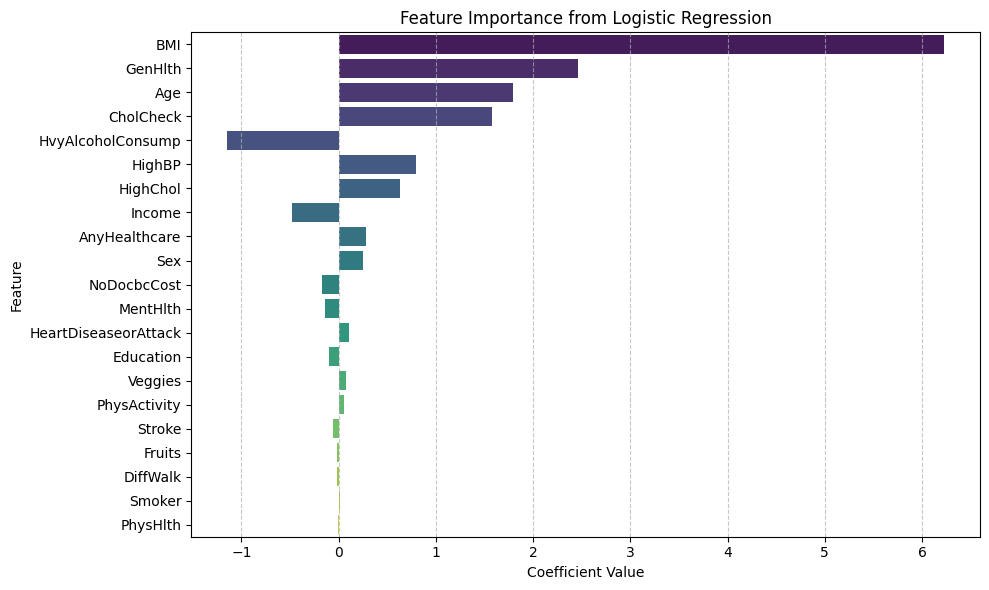

In [125]:
# Load data used for fitting
X_train, y_train = dataframes['X_train_BoxCox'], dataframes['y_train'].squeeze()
X_test, y_test = dataframes['X_test_BoxCox'], dataframes['y_test'].squeeze()

# apply transformations
X_train, y_train = undersample_train_data(X_train, y_train)
X_train, y_train = apply_SMOTE(X_train, y_train)
X_train, X_test = scale_features(X_train, X_test)

# map coef_ to feature names
feature_names = X_train.columns
coef_dict = {feature: coef for feature, coef in zip(feature_names, models['LR'].coef_[0])}
coef_dict = dict(sorted(coef_dict.items(), key=lambda item: item[1], reverse=True))
coef_df = pd.DataFrame(coef_dict.items(), columns=['Feature', 'Coefficient'])
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
plt.title('Feature Importance from Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Logistic Regression feature importance using SHAP analysis

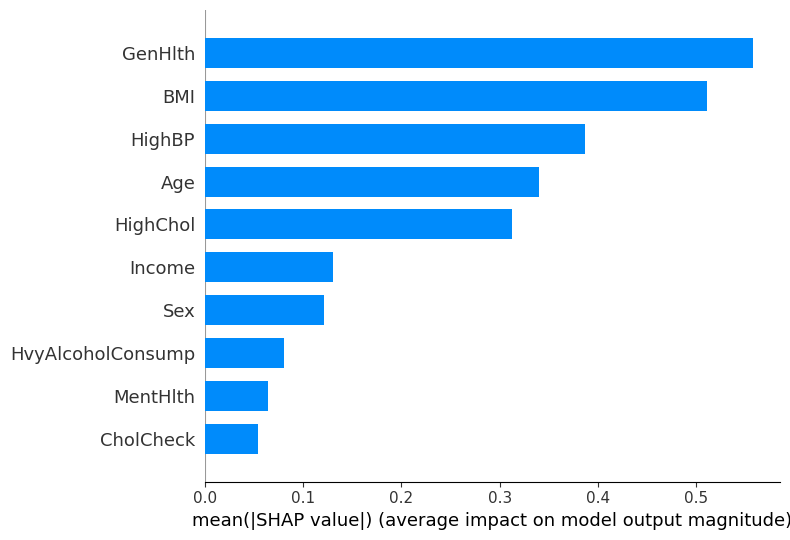

In [134]:
X_train = X_train.drop(columns=['target']) if 'target' in X_train.columns else X_train

# Logistic regression feature importance using SHAP
explainer = shap.Explainer(models['LR'], X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=10)